In [1]:
%matplotlib notebook

import numpy as np

# Synthetic Data (4 Layers, 10 Time Steps)

In [5]:
from multidynet.datasets import simple_dynamic_multilayer_network
from multidynet.plots import plot_network

Y, X, lmbda, intercept = simple_dynamic_multilayer_network(
    n_nodes=100, n_time_steps=10,
    tau_sq=4.0, sigma_sq=0.1,
    lmbda_scale=2.0, intercept=0.5,
    assortative_reference=False,
    random_state=423)

# Disassortative Layer

<IPython.core.display.Javascript object>


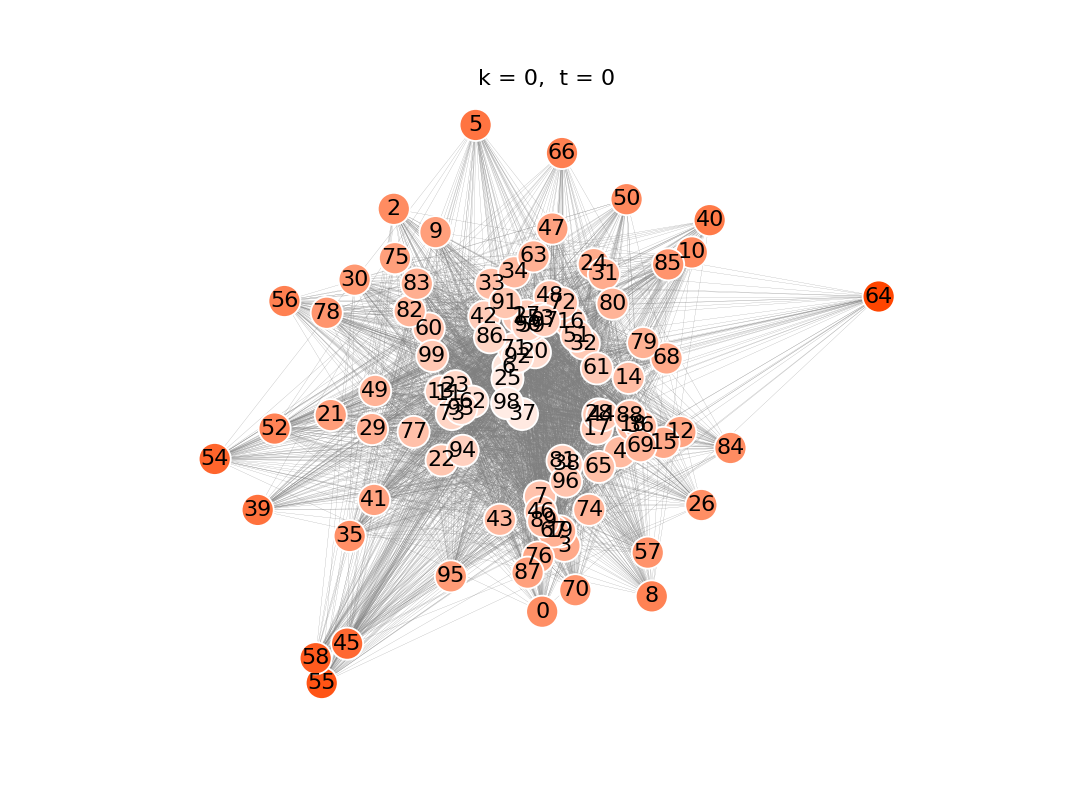

Text(0.5, 1.0, 'k = 0,  t = 0')

In [11]:
t = 0
k = 0

ax = plot_network(Y[k, t], X[t], normalize=False, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

<IPython.core.display.Javascript object>


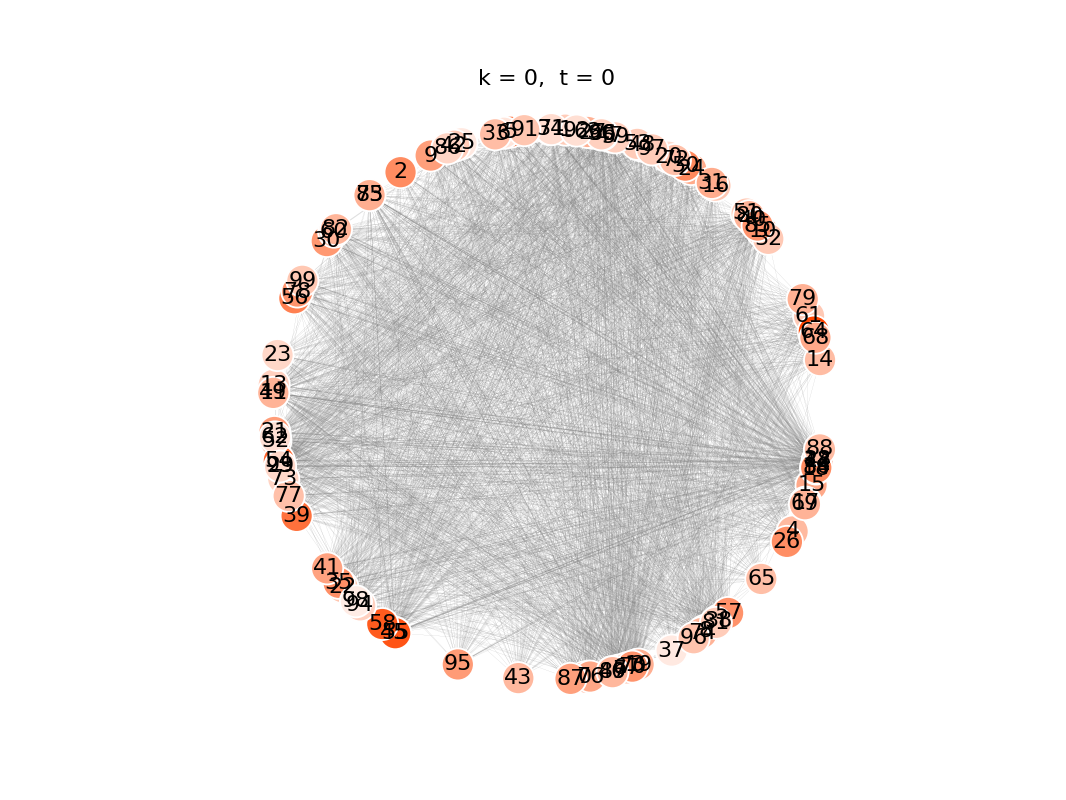

Text(0.5, 1.0, 'k = 0,  t = 0')

In [9]:
t = 0
k = 0

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.05)
ax.set_title('k = {},  t = {}'.format(k, t))

# Assortative Layer

<IPython.core.display.Javascript object>


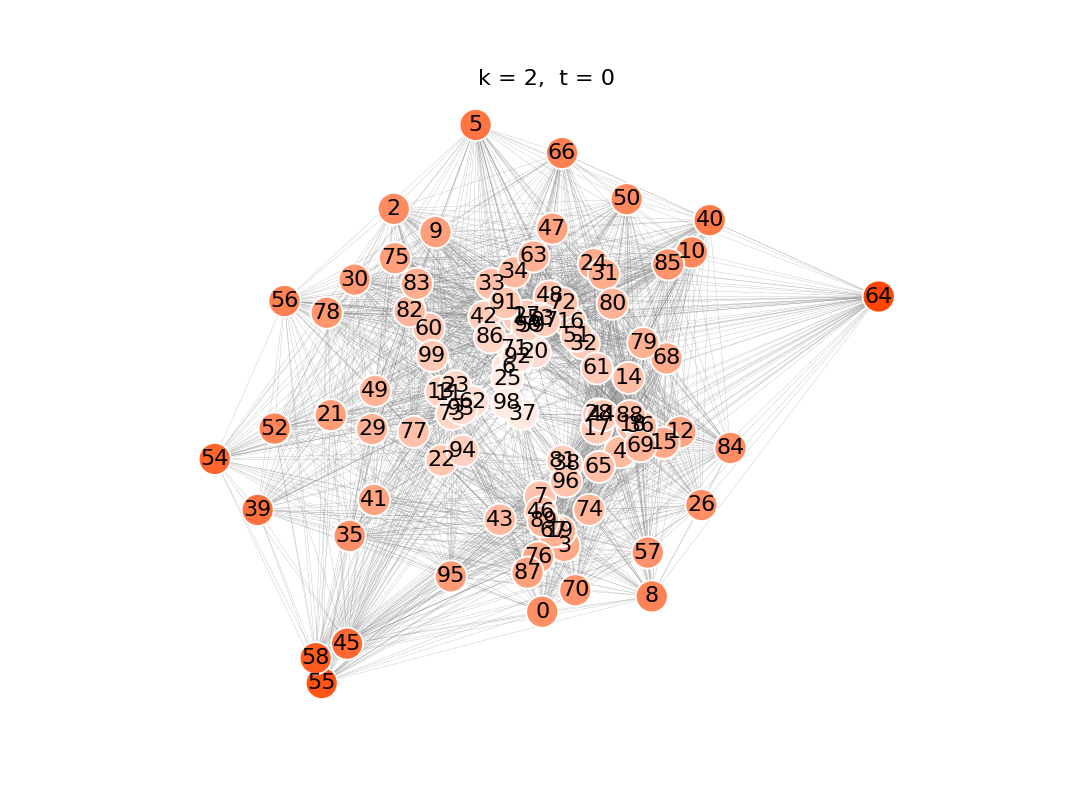

Text(0.5, 1.0, 'k = 2,  t = 0')

In [12]:
t = 0
k = 2

ax = plot_network(Y[k, t], X[t], normalize=False, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

<IPython.core.display.Javascript object>


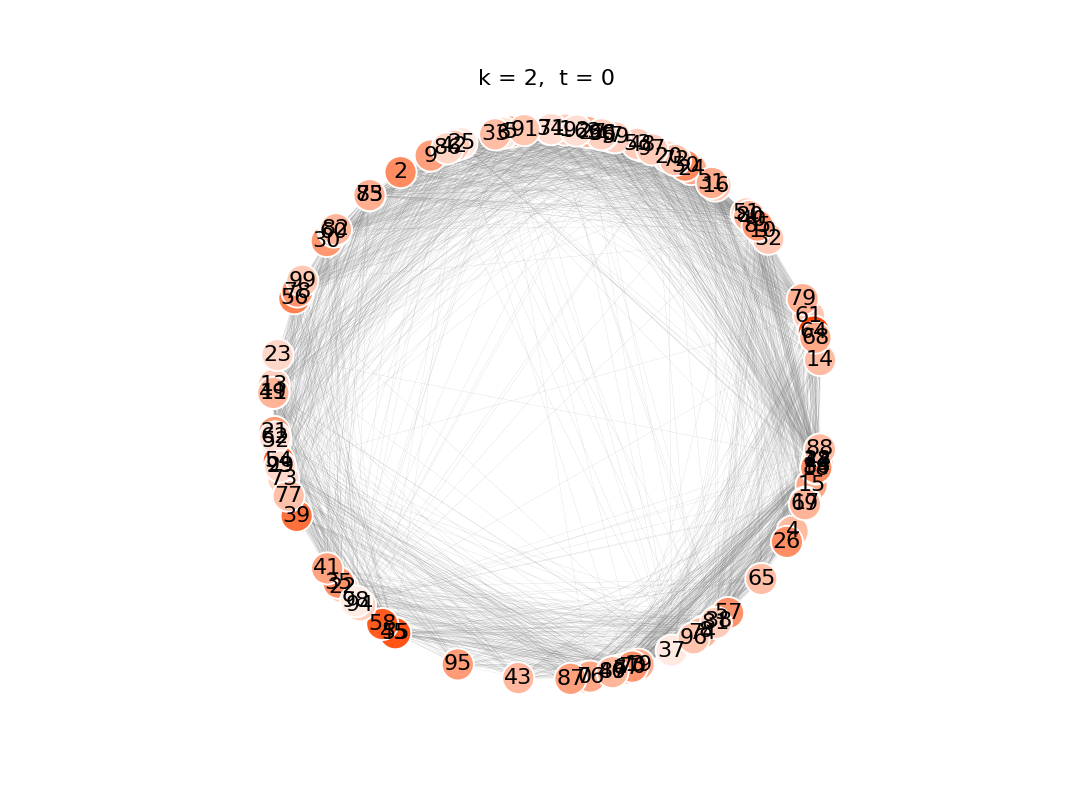

Text(0.5, 1.0, 'k = 2,  t = 0')

In [13]:
t = 0
k = 2

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.05)
ax.set_title('k = {},  t = {}'.format(k, t))

# Model Estimation

In [25]:
from multidynet import DynamicMultilayerNetworkLSM
from multidynet.model_selection import train_test_split

# Hold-out 10% of dyads for testing
Y_train, test_indices = train_test_split(Y, test_size=0.1)

model = DynamicMultilayerNetworkLSM(max_iter=5000,
                                    a=4.0, b=20.0, c=10, d=0.1, 
                                    lambda_var_prior=10., 
                                    intercept_var_prior=10.,
                                    lambda_odds_prior=2,
                                    n_init=5,
                                    random_state=0)
model.fit(Y_train)

<IPython.core.display.Javascript object>


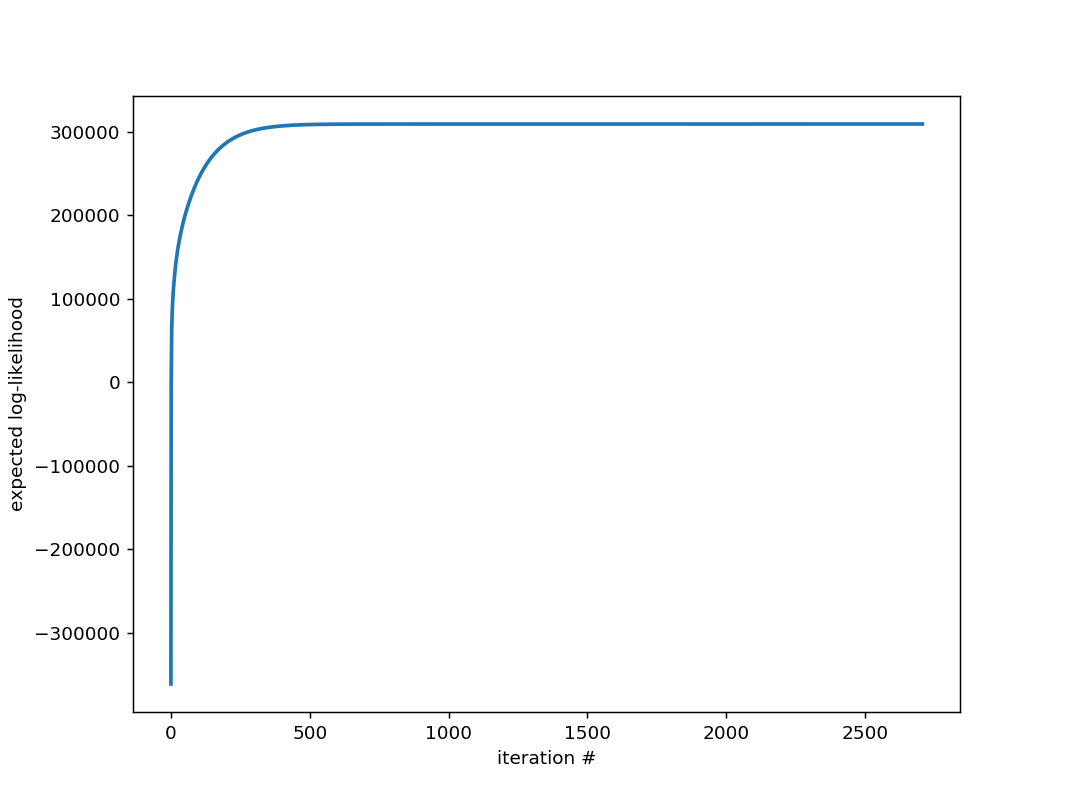

Text(0.5, 0, 'iteration #')

In [3]:
fig, ax= plt.subplots(figsize=(8, 6))
ax.plot(model.logp_, lw=2)
ax.set_ylabel('expected log-likelihood')
ax.set_xlabel('iteration #')

# Parameter Estimates

# $\Lambda_k$

In [27]:
model.lambda_

array([[-1.        , -1.        ],
       [-1.88329542, -1.91452543],
       [ 1.86756373,  1.90423852],
       [ 0.98786753,  1.0132961 ]])

In [28]:
model.lambda_proba_

array([0., 0.])

In [29]:
model.lambda_sigma_

array([[[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[2.62213726e-05, 7.34160024e-06],
        [7.34160024e-06, 2.97420814e-05]],

       [[2.58651072e-05, 7.40444087e-06],
        [7.40444087e-06, 2.94866574e-05]],

       [[1.47323369e-05, 3.16493526e-06],
        [3.16493526e-06, 1.71985202e-05]]])

# $\beta_k$

In [30]:
model.intercept_

array([0.50924124, 0.49980873, 0.50048705, 0.5212123 ])

In [31]:
model.intercept_sigma_

array([0.00016035, 0.00022428, 0.0002226 , 0.00016045])

# $\tau^2$

In [32]:
model.tau_sq_

4.247796974923615

# $\sigma^2$

In [33]:
model.sigma_sq_

0.7685458854997222

## Latent Space

<IPython.core.display.Javascript object>


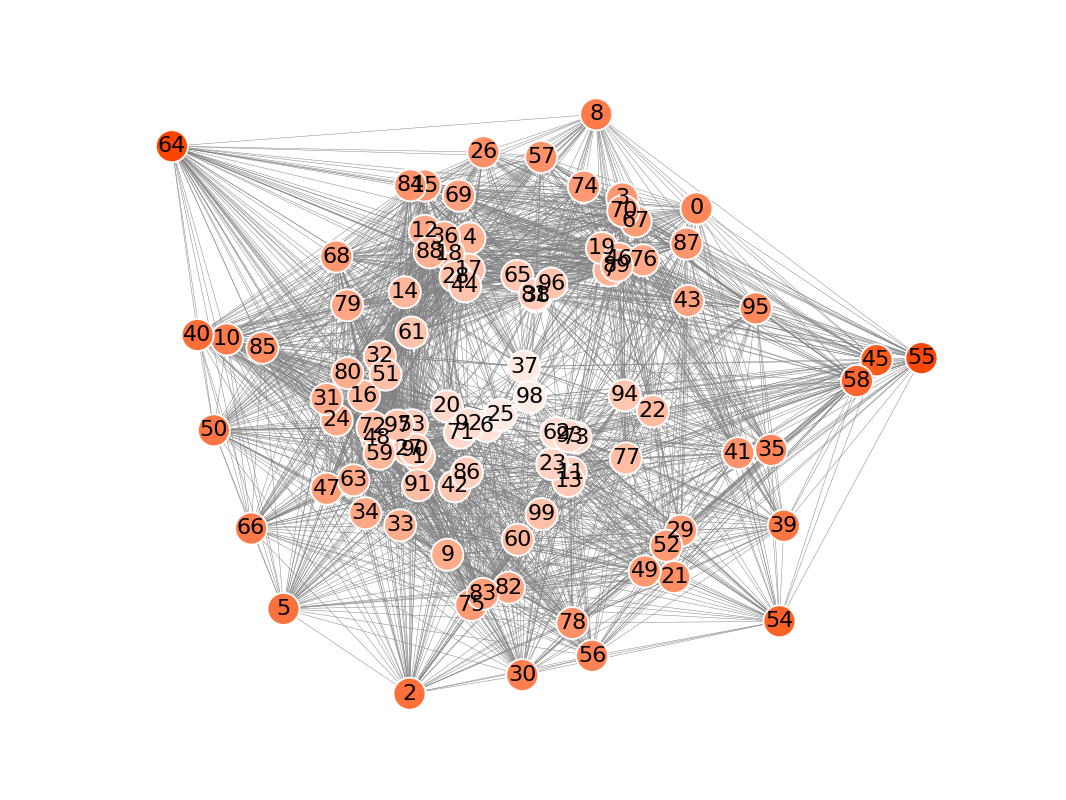

In [35]:
from multidynet.plots import plot_network

t = 0
k = 2
ax = plot_network(Y[k, t],model.X_[t], normalize=False, with_labels=True)

# Performance Diagnostics

## In-Sample AUC

In [36]:
model.auc_

0.9799081011560848

## Held-Out AUC

In [37]:
from multidynet.metrics import calculate_auc

calculate_auc(Y, model.probas_, test_indices)

0.9780606064837992

## Connection Probability Estimation

<IPython.core.display.Javascript object>


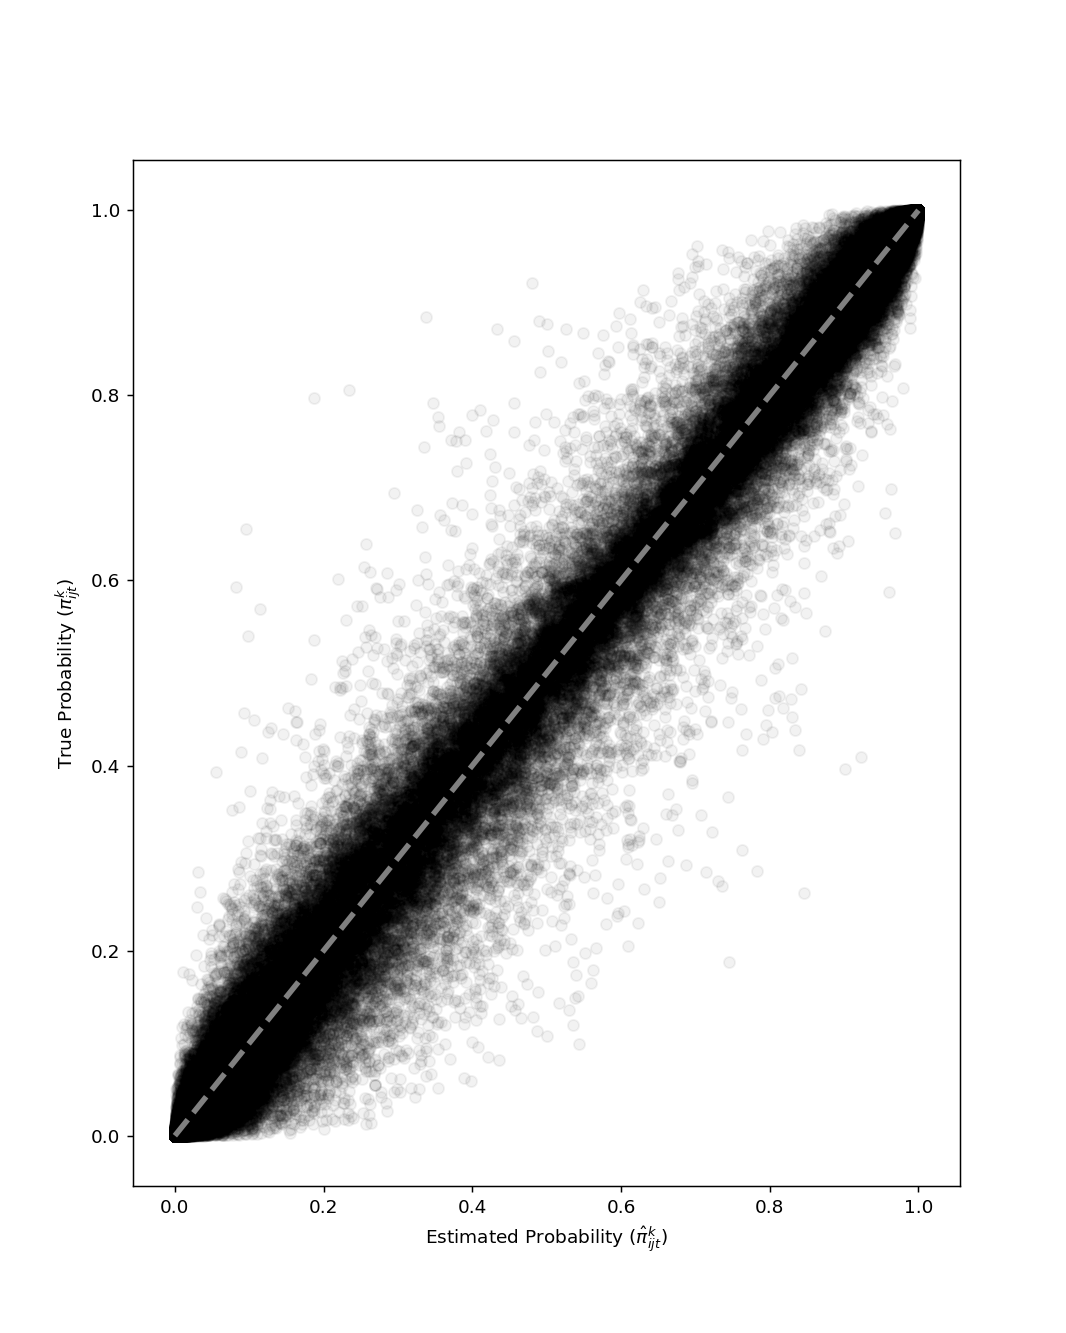

Text(0.5, 0, 'Estimated Probability ($\\hat{\\pi}_{ijt}^k$)')

In [38]:
import seaborn as sns
from scipy.special import expit

fig, ax = plt.subplots(figsize=(8, 10))

n_layers = Y.shape[0]
n_time_steps = X.shape[0]
n_nodes = X.shape[1]
n_dists = int(0.5 * n_nodes * (n_nodes - 1))

p_true = np.zeros((n_layers, n_time_steps, n_dists))
p_est = np.zeros((n_layers, n_time_steps, n_dists))
for k in range(n_layers):
    for t in range(n_time_steps):
        d_est = expit(
            model.intercept_[k] + np.dot(model.X_[t] * model.lambda_[k], model.X_[t].T))
        d_true = expit(intercept[k] + np.dot(X[t] * lmbda[k], X[t].T))

        indices = np.tril_indices_from(d_est, k=-1)
        p_true[k, t] = d_true[indices]
        p_est[k, t] = d_est[indices]

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, '--', color='gray', lw=3)
ax.scatter(p_est.ravel(), p_true.ravel(), alpha=0.05, c='k')
ax.set_ylabel('True Probability ($\pi_{ijt}^k$)')
ax.set_xlabel('Estimated Probability ($\hat{\pi}_{ijt}^k$)')

## Dot Product Estimation

<IPython.core.display.Javascript object>


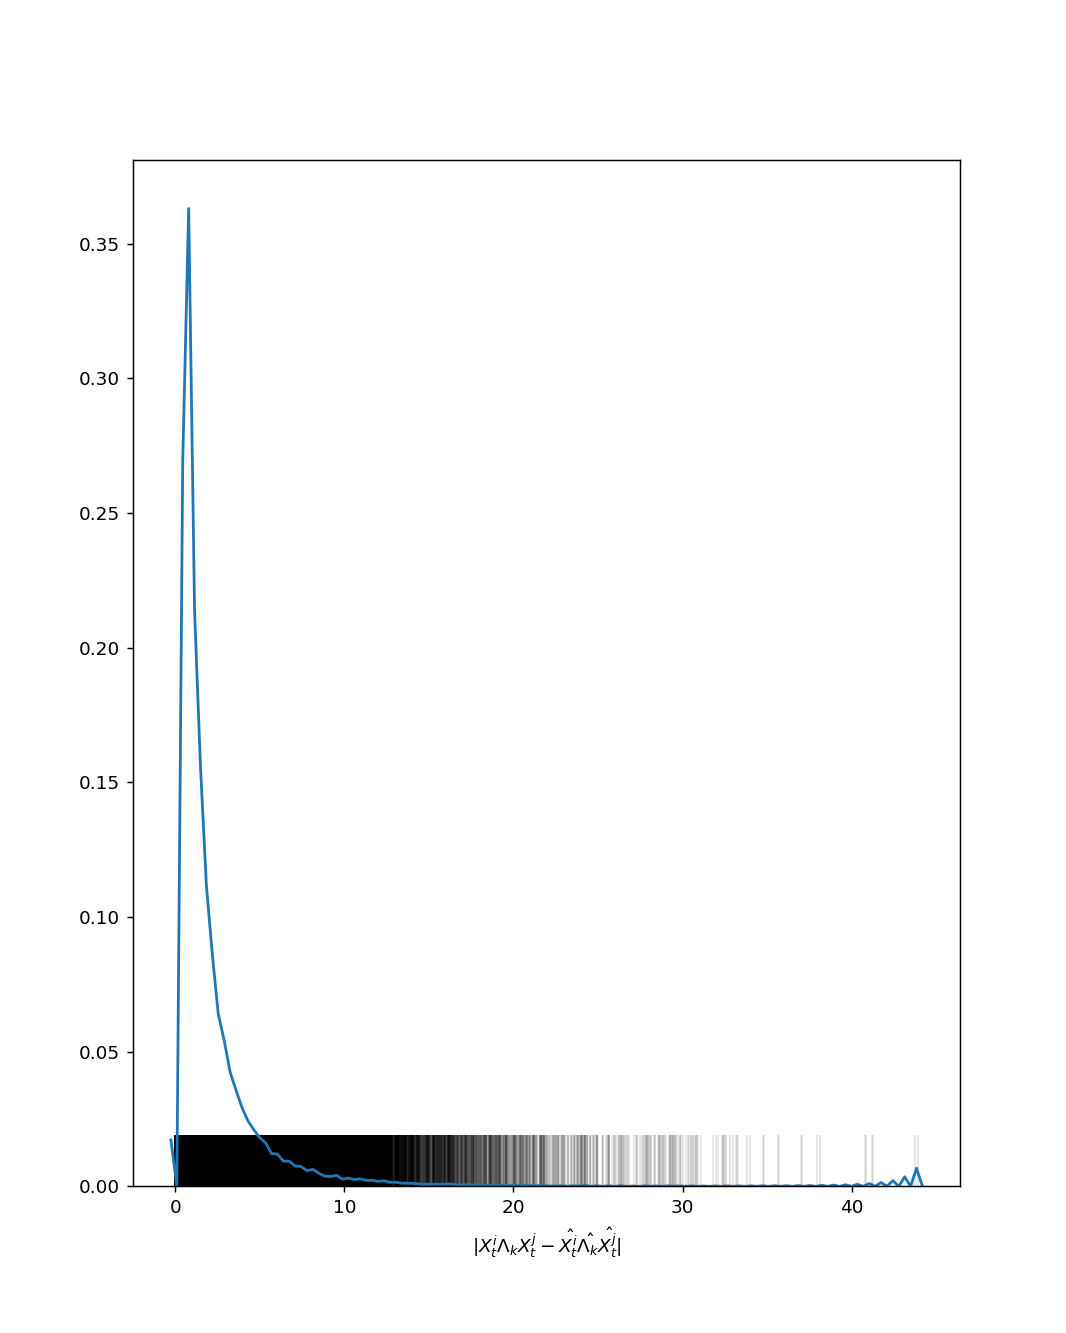

In [39]:
import seaborn as sns
from scipy.special import expit

fig, ax = plt.subplots(figsize=(8, 10))

n_layers = Y.shape[0]
n_time_steps = X.shape[0]
n_nodes = X.shape[1]
n_dists = int(0.5 * n_nodes * (n_nodes - 1))
error = np.zeros((n_layers, n_time_steps, n_dists))
for k in range(n_layers):
    for t in range(n_time_steps):
        d_est = np.dot(model.X_[t] * model.lambda_[k], model.X_[t].T)
        d_true = np.dot(X[t] * lmbda[k], X[t].T)

        r = np.abs(d_est - d_true) 
        error[k, t] = r[np.tril_indices_from(r, k=-1)]

sns.distplot(error.ravel(), rug=True, hist=False, rug_kws={'color': 'k', 'alpha': 0.1})

ax.set_xlabel('$|X_t^i \Lambda_k X_t^j - \hat{X_t^i} \hat{\Lambda_k} \hat{X_t^j}|$');

<IPython.core.display.Javascript object>


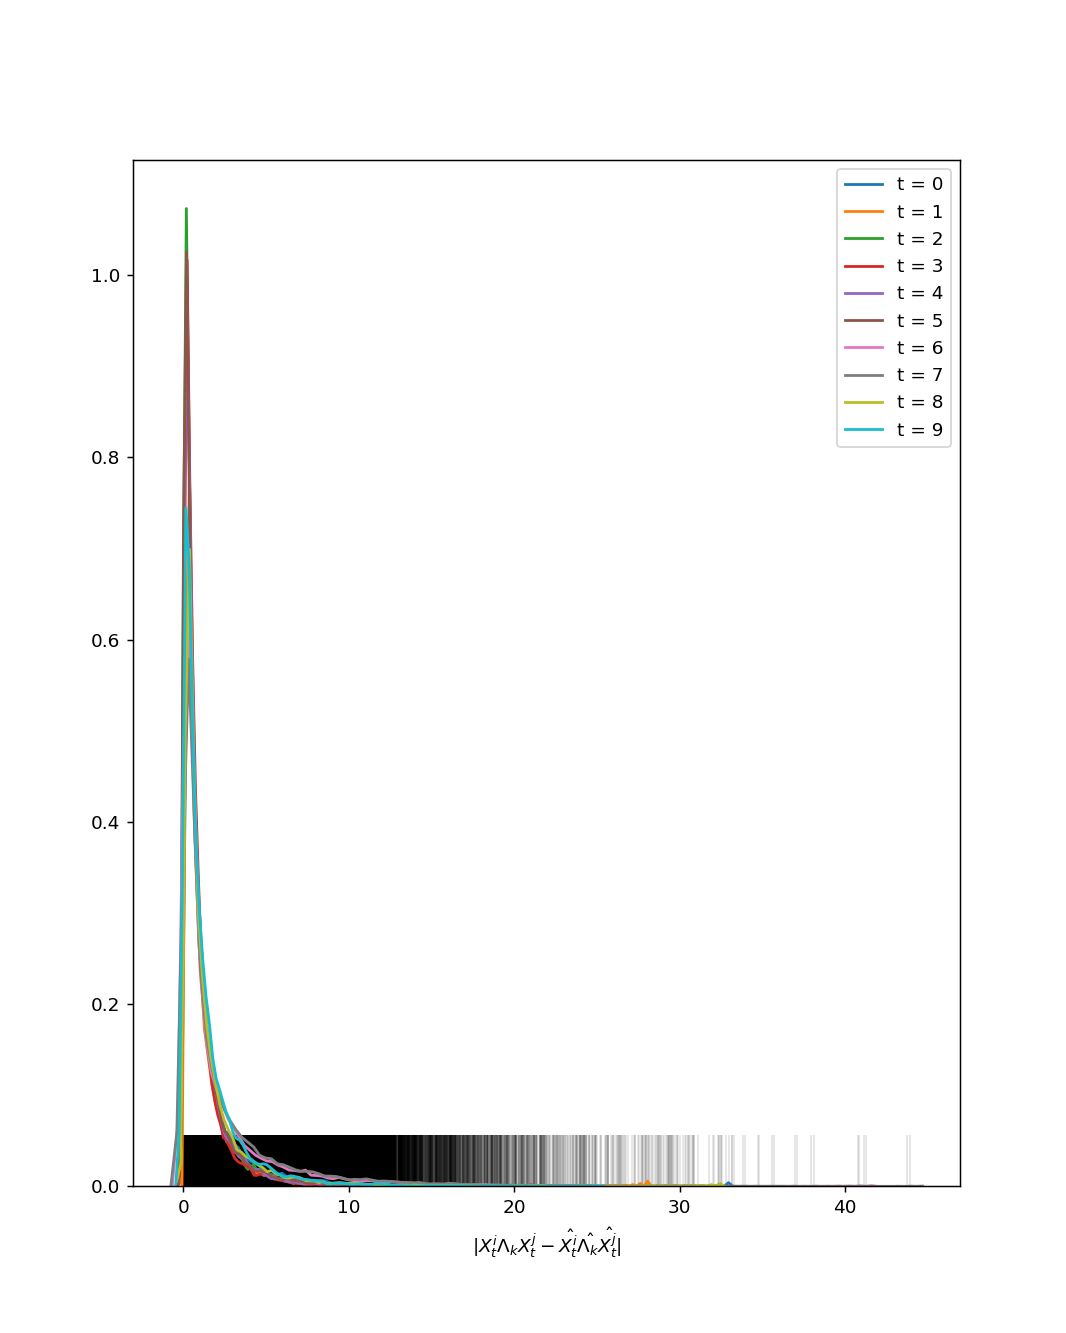

In [6]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 10))

n_layers = Y.shape[0]
n_time_steps = X.shape[0]
n_nodes = X.shape[1]
n_dists = int(0.5 * n_nodes * (n_nodes - 1))
error = np.zeros((n_time_steps, n_layers * n_dists))
for t in range(n_time_steps):
    for k in range(n_layers):
        d_est = np.dot(model.X_[t] * model.lambda_[k], model.X_[t].T)
        d_true = np.dot(X[t] * lmbda[k], X[t].T)
        
        indices = np.tril_indices_from(d_true, k=-1)
        r = np.abs((d_est[indices] - d_true[indices]))
        error[t, (k * n_dists):(k+1)*n_dists] = r#r[np.tril_indices_from(r, k=-1)]

    sns.distplot(error[t], rug=True, hist=False,
                 rug_kws={'color': 'k', 'alpha': 0.1},
                 label='t = {}'.format(t))

ax.set_xlabel('$|X_t^i \Lambda_k X_t^j - \hat{X_t^i} \hat{\Lambda_k} \hat{X_t^j}|$');

<IPython.core.display.Javascript object>


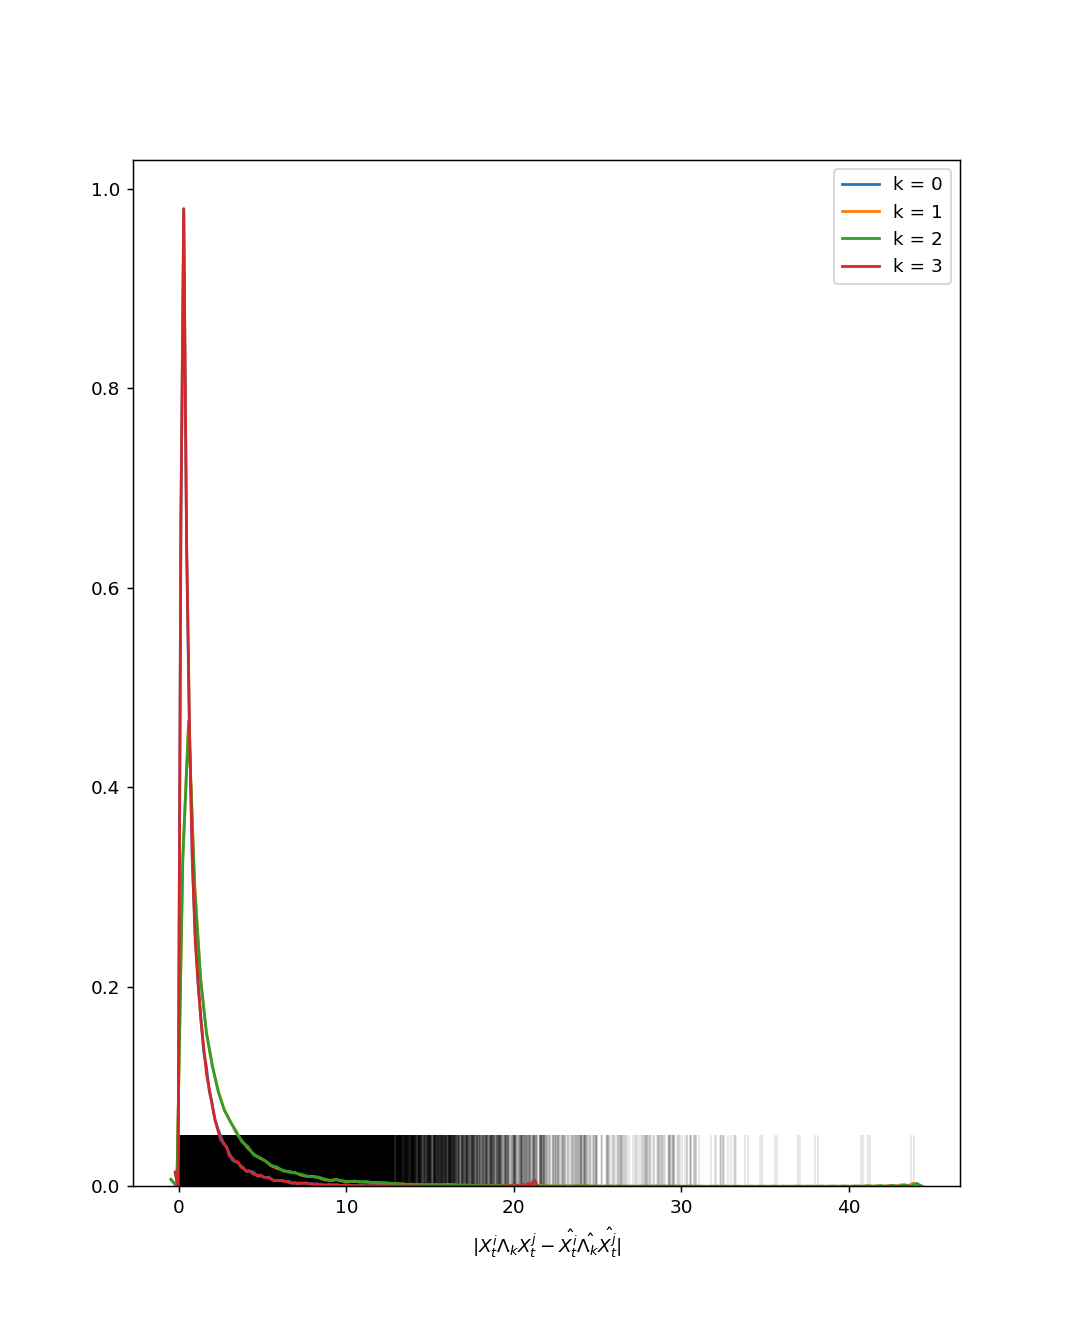

In [7]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 10))

n_layers = Y.shape[0]
n_time_steps = X.shape[0]
n_nodes = X.shape[1]
n_dists = int(0.5 * n_nodes * (n_nodes - 1))
error = np.zeros((n_layers, n_time_steps * n_dists))
for k in range(n_layers):
    for t in range(n_time_steps):
        d_est = np.dot(model.X_[t] * model.lambda_[k], model.X_[t].T)
        d_true = np.dot(X[t] * lmbda[k], X[t].T)
        
        indices = np.tril_indices_from(d_true, k=-1)
        r = np.abs((d_est[indices] - d_true[indices]))
        error[k, (t * n_dists):(t+1)*n_dists] = r#r[np.tril_indices_from(r, k=-1)]

    sns.distplot(error[k], rug=True, hist=False, 
                 rug_kws={'color': 'k', 'alpha': 0.1},
                 label='k = {}'.format(k))

ax.set_xlabel('$|X_t^i \Lambda_k X_t^j - \hat{X_t^i} \hat{\Lambda_k} \hat{X_t^j}|$');

In [42]:
import pickle

pickle.dump(model, open('test_model_n100_t10.pkl', 'wb'))